## Moving Average Indicator Analysis

This notebook investigates whether **Moving Average (MA)** indicators contain **predictive power** in the cryptocurrency market.

Following the approach of *Avramov, Kaplanski, and Subrahmanyam (2018)*, we examine the **Moving Average Distance (MAD)** — the difference between short- and long-term moving averages — as a potential signal for future returns.

### Objective
To identify which (short, long) moving average window combination best predicts short-term price movements across cryptocurrencies.

### Methodology
1. Compute the **MAD** for multiple (short, long) MA window pairs.  
2. Test the predictive power of each pair by regressing **future returns** on the MAD.  
3. Evaluate results across multiple horizons and coins.  
4. Select the window combination that shows the **strongest and most consistent** predictive relationship.

### Key Findings
- The MAD shows **weak but consistent predictive power** — indicating mild mean-reversion behavior in most coins.  
- This suggests that momentum-based indicators alone have limited strength, but can still contribute useful information when **combined with additional features** such as volume, volatility, or sentiment measures.

### Next Steps
Use the optimal MA configuration as one component in a broader multi-feature model to improve predictive performance.


In [32]:
import pandas as pd
import re
import numpy as np
import os
import multiprocessing as mp
import logging
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns', 700)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all columns
pd.set_option('display.float_format', '{:.5f}'.format)

In [33]:
df_long = pd.read_csv("Data/DF_Combined_2025_1h_Processed.csv")
df_long.head()

,coin,date,RET,close,high,low,open,volume
0,AAVEUSDT,2024-12-31 23:00:00,-0.00287,308.70000,311.66000,307.85000,309.59000,16569.70000
1,AAVEUSDT,2025-01-01 00:00:00,0.01591,313.61000,313.72000,308.72000,308.73000,27473.90000
2,AAVEUSDT,2025-01-01 01:00:00,-0.00077,313.37000,314.28000,311.37000,313.61000,23172.20000
3,AAVEUSDT,2025-01-01 02:00:00,0.00377,314.55000,316.92000,313.21000,313.37000,26176.50000
4,AAVEUSDT,2025-01-01 03:00:00,-0.00741,312.22000,314.58000,311.81000,314.53000,13005.10000


### Moving Average Difference (MAD) as a Momentum Signal

The **Moving Average Difference (MAD)** is a fundamental **trend-following momentum indicator** that measures the difference between a short-term trend and a long-term trend.

It is calculated by finding the difference between a **Short-Term Moving Average (SMA)** and a **Long-Term Moving Average (LMA)** of a coin's price.

$$\text{MAD} = \text{SMA}_{\text{Short}} - \text{LMA}_{\text{Long}}$$

* **What it tells you:** It measures how strongly and quickly the asset's current price trend is moving relative to its historical, underlying trend.
* **Interpretation:**
    * **Positive MAD:** The asset's price is rising faster than its long-term average (bullish momentum).
    * **Negative MAD:** The asset's price is falling faster than its long-term average (bearish momentum).

***

### The Normalized Momentum Feature

Since raw MAD values are in price units and are **not comparable** across different coins (e.g., a \$10 MAD for Bitcoin vs. a \$10 MAD for a penny coin), we must **normalize** it.

The **Normalized Momentum Feature** is created by dividing the raw MAD by the long-term average price, converting it into a **percentage difference**:

$$\text{Normalized Momentum} = \frac{\text{SMA}_{\text{Short}} - \text{LMA}_{\text{Long}}}{\text{LMA}_{\text{Long}}}$$

This final feature is **cross-sectionally comparable**: a value of **+0.10** means the short-term trend is **10% higher** than the long-term trend, regardless of the coin's absolute price.

In [34]:
# --- Define the Windows to Test (in hours) ---
# --- Define the Windows to Test (in hours) ---

# Intraday windows (short-term signals)
SHORT_WINDOWS = [5, 10, 20, 30, 50]

# Medium-term windows (longer MAs in hours)
LONG_WINDOWS = [20, 50, 100, 150, 250]

# --- Add Daily-based Periods ---
# 24 hours = 1 day
DAILY_WINDOWS_SHORT = [24, 72, 120]        # 1D, 3D, 5D equivalents
DAILY_WINDOWS_LONG  = [168, 336, 720]      # 1W, 2W, 1M equivalents

# --- Combine all ---
SHORT_WINDOWS += DAILY_WINDOWS_SHORT
LONG_WINDOWS  += DAILY_WINDOWS_LONG

# Ensure the DataFrame is sorted by coin and date for accurate rolling calculation
long_df = df_long.sort_values(by=['coin', 'date'])

# --- Loop Through All Valid Combinations ---
for short_w in SHORT_WINDOWS:
    for long_w in LONG_WINDOWS:
        # A valid momentum signal requires the short window to be shorter than the long window
        if short_w < long_w:
            
            # 1. Define Column Names
            col_name_sma = f'SMA_{short_w}'
            col_name_lma = f'LMA_{long_w}'
            momentum_col_name = f'Mom_S{short_w}_L{long_w}'
            
            # 2. Calculate the Long-Term Moving Average (LMA)
            # We calculate the LMA first, as it has the largest min_periods requirement
            long_df[col_name_lma] = long_df.groupby('coin')['close'].transform(
                lambda x: x.rolling(window=long_w, min_periods=long_w).mean()
            )
            
            # 3. Calculate the Short-Term Moving Average (SMA)
            long_df[col_name_sma] = long_df.groupby('coin')['close'].transform(
                lambda x: x.rolling(window=short_w, min_periods=short_w).mean()
            )
            
            # 4. Calculate the Normalized Momentum Feature (MAD / LMA)
            # Formula: (SMA_Short - LMA_Long) / LMA_Long
            long_df[momentum_col_name] = (
                long_df[col_name_sma] - long_df[col_name_lma]
            ) / long_df[col_name_lma]

            # 5. Clean up the temporary SMA and LMA columns
            long_df = long_df.drop(columns=[col_name_sma, col_name_lma])


# Remove initial rows that don't have a full history for the longest window (LMA_100)
# We must use the largest window size (100 in this case) for the final dropna.
# Note: The dropna below will clean up all rows where the longest feature is NaN.
long_df = long_df.dropna(subset=[f'Mom_S{short_w}_L{long_w}' for short_w in SHORT_WINDOWS for long_w in LONG_WINDOWS if short_w < long_w])

print("Calculated Momentum Features:")
long_df.tail()

Calculated Momentum Features:


,coin,date,RET,close,high,low,open,volume,Mom_S5_L20,Mom_S5_L50,Mom_S5_L100,Mom_S5_L150,Mom_S5_L250,Mom_S5_L168,Mom_S5_L336,Mom_S5_L720,Mom_S10_L20,Mom_S10_L50,Mom_S10_L100,Mom_S10_L150,Mom_S10_L250,Mom_S10_L168,Mom_S10_L336,Mom_S10_L720,Mom_S20_L50,Mom_S20_L100,Mom_S20_L150,Mom_S20_L250,Mom_S20_L168,Mom_S20_L336,Mom_S20_L720,Mom_S30_L50,Mom_S30_L100,Mom_S30_L150,Mom_S30_L250,Mom_S30_L168,Mom_S30_L336,Mom_S30_L720,Mom_S50_L100,Mom_S50_L150,Mom_S50_L250,Mom_S50_L168,Mom_S50_L336,Mom_S50_L720,Mom_S24_L50,Mom_S24_L100,Mom_S24_L150,Mom_S24_L250,Mom_S24_L168,Mom_S24_L336,Mom_S24_L720,Mom_S72_L100,Mom_S72_L150,Mom_S72_L250,Mom_S72_L168,Mom_S72_L336,Mom_S72_L720,Mom_S120_L150,Mom_S120_L250,Mom_S120_L168,Mom_S120_L336,Mom_S120_L720
284965,ZECUSDT,2025-10-10 11:00:00,-0.01495,228.04000,234.05000,227.18000,231.51000,128628.06100,0.02595,0.19301,0.35387,0.39665,0.60047,0.42213,0.88255,1.73174,0.05513,0.22695,0.39238,0.43638,0.64599,0.46258,0.93609,1.80943,0.16284,0.31963,0.36133,0.55999,0.38616,0.83493,1.66264,0.09277,0.24011,0.27930,0.46599,0.30263,0.72437,1.50220,0.13483,0.17069,0.34153,0.19205,0.57797,1.28978,0.13275,0.28548,0.32610,0.51962,0.35029,0.78745,1.59374,0.03034,0.06289,0.21800,0.08228,0.43267,1.07893,0.02015,0.16902,0.03876,0.37506,0.99533
284966,ZECUSDT,2025-10-10 12:00:00,0.02359,233.42000,235.11000,220.00000,228.03000,227096.27300,0.02120,0.18800,0.35577,0.39868,0.60203,0.42534,0.88471,1.73845,0.04381,0.21431,0.38579,0.42965,0.63750,0.45690,0.92644,1.79908,0.16334,0.32762,0.36964,0.56877,0.39574,0.84558,1.68159,0.09144,0.24557,0.28500,0.47182,0.30949,0.73153,1.51587,0.14122,0.17734,0.34851,0.19978,0.58646,1.30509,0.13030,0.28992,0.33075,0.52422,0.35611,0.79318,1.60545,0.03319,0.06589,0.22085,0.08620,0.43628,1.08688,0.02032,0.16865,0.03976,0.37487,0.99765
284967,ZECUSDT,2025-10-10 13:00:00,0.03676,242.00000,244.00000,233.35000,233.40000,216600.70900,0.02141,0.18666,0.36239,0.40565,0.60932,0.43372,0.89373,1.75528,0.03895,0.20703,0.38577,0.42978,0.63695,0.45834,0.92624,1.80258,0.16178,0.33382,0.37618,0.57558,0.40367,0.85403,1.69752,0.09072,0.25224,0.29201,0.47922,0.31781,0.74063,1.53253,0.14809,0.18455,0.35618,0.20820,0.59585,1.32189,0.13011,0.29746,0.33866,0.53263,0.36540,0.80348,1.62398,0.03646,0.06937,0.22432,0.09073,0.44068,1.09613,0.02058,0.16845,0.04096,0.37495,1.00048
284968,ZECUSDT,2025-10-10 14:00:00,-0.02955,234.85000,243.00000,231.03000,242.03000,177614.38200,0.01716,0.17578,0.35704,0.40013,0.60213,0.42931,0.88567,1.74715,0.03286,0.19392,0.37798,0.42174,0.62686,0.45136,0.91477,1.78954,0.15594,0.33414,0.37651,0.57510,0.40519,0.85385,1.70079,0.09217,0.26054,0.30057,0.48821,0.32767,0.75158,1.55180,0.15416,0.19081,0.36261,0.21563,0.60376,1.33645,0.12901,0.30306,0.34444,0.53840,0.37245,0.81067,1.63787,0.04048,0.07353,0.22841,0.09590,0.44580,1.10632,0.02079,0.16807,0.04206,0.37478,1.00286
284969,ZECUSDT,2025-10-10 15:00:00,-0.07622,216.95000,235.56000,201.12000,234.85000,504531.52200,0.00381,0.15283,0.33664,0.37819,0.57580,0.40811,0.85497,1.70554,0.01150,0.16166,0.34688,0.38875,0.58787,0.41889,0.86918,1.72626,0.14845,0.33156,0.37296,0.56981,0.40275,0.84792,1.69525,0.09094,0.26488,0.30421,0.49120,0.33251,0.75539,1.56029,0.15944,0.19549,0.36690,0.22144,0.60906,1.34687,0.12693,0.30662,0.34724,0.54040,0.37648,0.81330,1.64476,0.04417,0.07663,0.23099,0.09999,0.44908,1.11353,0.02080,0.16716,0.04296,0.37394,1.00394


In [35]:
# Define the look-ahead periods (in hours)
HORIZONS = [1, 2, 5, 10, 24, 24*3, 24*5, 24*7, 24*14, 24*30]

# 1. Create the future return columns
for h in HORIZONS:
    # Column name will be 'Future_RET_H' where H is the horizon
    col_name = f'Future_RET_{h}H'
    
    
    # --- Correct approach for cumulative future return (Gross Return Product) ---
    def calculate_future_cumulative_return(group, hours):
        # Calculate the cumulative gross return (1 + R_t) * (1 + R_t+1) ... (1 + R_t+h-1)
        gross_return = (1 + group['RET']).rolling(window=hours).apply(lambda x: x.prod(), raw=True)
        # Shift back by 'hours' and subtract 1 to get the simple cumulative return from t to t+h
        future_return = gross_return.shift(-hours) - 1
        return future_return

    long_df[col_name] = long_df.groupby('coin').apply(
        lambda x: calculate_future_cumulative_return(x, h), 
        include_groups=False
    ).reset_index(level=0, drop=True)
    

# Drop rows where the target return cannot be calculated (at the end of the time series)
long_df = long_df.dropna(subset=[f'Future_RET_{h}H' for h in HORIZONS])
long_df.head()

,coin,date,RET,close,high,low,open,volume,Mom_S5_L20,Mom_S5_L50,Mom_S5_L100,Mom_S5_L150,Mom_S5_L250,Mom_S5_L168,Mom_S5_L336,Mom_S5_L720,Mom_S10_L20,Mom_S10_L50,Mom_S10_L100,Mom_S10_L150,Mom_S10_L250,Mom_S10_L168,Mom_S10_L336,Mom_S10_L720,Mom_S20_L50,Mom_S20_L100,Mom_S20_L150,Mom_S20_L250,Mom_S20_L168,Mom_S20_L336,Mom_S20_L720,Mom_S30_L50,Mom_S30_L100,Mom_S30_L150,Mom_S30_L250,Mom_S30_L168,Mom_S30_L336,Mom_S30_L720,Mom_S50_L100,Mom_S50_L150,Mom_S50_L250,Mom_S50_L168,Mom_S50_L336,Mom_S50_L720,Mom_S24_L50,Mom_S24_L100,Mom_S24_L150,Mom_S24_L250,Mom_S24_L168,Mom_S24_L336,Mom_S24_L720,Mom_S72_L100,Mom_S72_L150,Mom_S72_L250,Mom_S72_L168,Mom_S72_L336,Mom_S72_L720,Mom_S120_L150,Mom_S120_L250,Mom_S120_L168,Mom_S120_L336,Mom_S120_L720,Future_RET_1H,Future_RET_2H,Future_RET_5H,Future_RET_10H,Future_RET_24H,Future_RET_72H,Future_RET_120H,Future_RET_168H,Future_RET_336H,Future_RET_720H
719,AAVEUSDT,2025-01-30 22:00:00,0.00574,317.18000,318.50000,314.04000,315.41000,9532.30000,0.01896,0.05724,0.05383,0.01802,-0.02853,0.00642,-0.02502,-0.00170,0.01868,0.05696,0.05355,0.01774,-0.02879,0.00615,-0.02528,-0.00197,0.03757,0.03423,-0.00092,-0.04660,-0.01231,-0.04316,-0.02027,0.01884,0.01555,-0.01897,-0.06382,-0.03014,-0.06044,-0.03796,-0.00323,-0.03710,-0.08113,-0.04807,-0.07781,-0.05575,0.02798,0.02467,-0.01016,-0.05542,-0.02144,-0.05200,-0.02933,-0.00478,-0.03860,-0.08256,-0.04956,-0.07924,-0.05722,-0.01883,-0.06369,-0.03001,-0.06031,-0.03783,-0.00574,0.00419,-0.00397,-0.00233,0.05372,-0.18668,-0.15622,-0.23126,-0.19572,-0.38414
720,AAVEUSDT,2025-01-30 23:00:00,-0.00574,315.36000,319.48000,315.13000,317.18000,15502.90000,0.01564,0.05408,0.05362,0.01799,-0.02893,0.00601,-0.02586,-0.00255,0.01647,0.05494,0.05448,0.01882,-0.02814,0.00683,-0.02506,-0.00173,0.03785,0.03739,0.00231,-0.04388,-0.00948,-0.04086,-0.01791,0.01941,0.01896,-0.01550,-0.06087,-0.02708,-0.05790,-0.03535,-0.00044,-0.03424,-0.07875,-0.04561,-0.07584,-0.05372,0.02916,0.02871,-0.00608,-0.05189,-0.01778,-0.04889,-0.02613,-0.00368,-0.03737,-0.08174,-0.04870,-0.07883,-0.05679,-0.01835,-0.06359,-0.02990,-0.06062,-0.03815,0.00999,0.01551,-0.00907,0.00821,0.05467,-0.18119,-0.13753,-0.23478,-0.18747,-0.38185
721,AAVEUSDT,2025-01-31 00:00:00,0.00999,318.51000,318.63000,313.26000,315.36000,25200.60000,0.01205,0.05060,0.05291,0.01763,-0.02953,0.00521,-0.02690,-0.00358,0.01420,0.05282,0.05514,0.01978,-0.02748,0.00734,-0.02484,-0.00147,0.03808,0.04037,0.00551,-0.04109,-0.00676,-0.03849,-0.01545,0.01983,0.02207,-0.01217,-0.05795,-0.02422,-0.05540,-0.03276,0.00220,-0.03138,-0.07627,-0.04320,-0.07377,-0.05157,0.03043,0.03269,-0.00191,-0.04817,-0.01409,-0.04558,-0.02271,-0.00253,-0.03595,-0.08063,-0.04771,-0.07813,-0.05604,-0.01794,-0.06345,-0.02992,-0.06091,-0.03841,0.00546,-0.00446,-0.00097,-0.00681,0.04000,-0.21889,-0.15943,-0.24351,-0.20134,-0.38956
722,AAVEUSDT,2025-01-31 01:00:00,0.00546,320.25000,320.41000,316.68000,318.50000,20953.70000,0.01291,0.05185,0.05686,0.02197,-0.02571,0.00904,-0.02337,-0.00002,0.01280,0.05174,0.05676,0.02187,-0.02581,0.00894,-0.02347,-0.00012,0.03844,0.04340,0.00895,-0.03813,-0.00381,-0.03582,-0.01276,0.02023,0.02509,-0.00875,-0.05500,-0.02129,-0.05273,-0.03008,0.00477,-0.02840,-0.07374,-0.04069,-0.07151,-0.04931,0.03146,0.03638,0.00216,-0.04460,-0.01052,-0.04230,-0.01940,-0.00141,-0.03438,-0.07943,-0.04660,-0.07722,-0.05516,-0.01746,-0.06330,-0.02989,-0.06106,-0.03860,-0.00987,-0.01352,0.00550,0.01686,0.02948,-0.32053,-0.16465,-0.23663,-0.20322,-0.39500
723,AAVEUSDT,2025-01-31 02:00:00,-0.00987,317.09000,320.75000,315.63000,320.25000,18808.80000,0.01164,0.05068,0.05827,0.02359,-0.02424,0.01037,-0.02229,0.00105,0.01049,0.04949,0.05707,0.02243,-0.02535,0.00923,-0.02340,-0.00008,0.03859,0.04610,0.01182,-0.03547,-0.00125,-0.03354,-0.01046,0.02032,0.02769,-0.00599,-0.05244,-0.01883,-0.05054,-0.02788,0.00722,-0.02578,-0.07131,-0.03837,-0.06945,-0.04723,0.03202,0.03948,0.00541,-0.04157,-0.00757,-0.03965,-0.01673,-0.00044,-0.03319,-0.07837,-0.04568,-0.07653,-0.05448,-0.01

In [36]:
def plot_coin_corr(
    long_df: pd.DataFrame,
    coin: str = "all",
    momentum_prefix: str = "Mom_S",
    target_prefix: str = "Future_RET_",
    figsize=(12, 9),
    annotate: bool = True
):
    """
    Plot the correlation matrix between momentum features and future-return targets
    for a specific coin or the average across all coins.

    Parameters
    ----------
    long_df : pd.DataFrame
        Long-format DataFrame containing a 'coin' column, momentum features, and targets.
    coin : str, default 'all'
        Coin name (e.g., 'BTCUSDT') or 'all' to average correlations across all coins.
    momentum_prefix : str, default 'Mom_S'
        Prefix for momentum feature columns.
    target_prefix : str, default 'Future_RET_'
        Prefix for future return target columns.
    figsize : tuple, default (8, 6)
        Figure size for the plot.
    annotate : bool, default True
        Whether to display correlation values on the plot.

    Returns
    -------
    pd.DataFrame
        Correlation matrix (momentum vs future returns).
    """
    if "coin" not in long_df.columns:
        raise ValueError("long_df must contain a 'coin' column.")

    # Identify columns
    momentum_cols = [c for c in long_df.columns if c.startswith(momentum_prefix)]
    target_cols   = [c for c in long_df.columns if c.startswith(target_prefix)]

    if not momentum_cols:
        raise ValueError(f"No momentum columns found with prefix '{momentum_prefix}'.")
    if not target_cols:
        raise ValueError(f"No target columns found with prefix '{target_prefix}'.")

    # Compute per-coin correlations
    coin_corrs = []

    coins_to_use = [coin] if coin != "all" else long_df["coin"].unique()

    for c in coins_to_use:
        coin_df = long_df[long_df["coin"] == c]
        if coin_df.empty:
            continue
        corr_full = coin_df.loc[:, momentum_cols + target_cols].corr()
        key_corr = corr_full.loc[momentum_cols, target_cols]
        coin_corrs.append(key_corr)

    if not coin_corrs:
        raise ValueError(f"No data found for coin(s): {coins_to_use}")

    # Average across all coins if needed
    if coin == "all":
        key_corr = pd.concat(coin_corrs).groupby(level=0).mean()
        title_coin = "All Coins (Average)"
    else:
        key_corr = coin_corrs[0]
        title_coin = coin

    # Plot
    plot_vals = key_corr.to_numpy()
    plot_vals_display = np.nan_to_num(plot_vals, nan=0.0)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(plot_vals_display, aspect="auto", vmin=-1, vmax=1)

    ax.set_yticks(range(len(momentum_cols)))
    ax.set_yticklabels(momentum_cols)
    ax.set_xticks(range(len(target_cols)))
    ax.set_xticklabels(target_cols, rotation=45, ha="right")

    ax.set_title(f"Correlation: Momentum vs Future Returns — {title_coin}")
    ax.set_xlabel("Future Return Targets")
    ax.set_ylabel("Momentum Features")

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Correlation")

    if annotate:
        for i in range(plot_vals.shape[0]):
            for j in range(plot_vals.shape[1]):
                val = key_corr.iat[i, j]
                text = "nan" if pd.isna(val) else f"{val:.2f}"
                ax.text(j, i, text, ha="center", va="center", fontsize=8)

    fig.tight_layout()
    plt.show()

    return key_corr


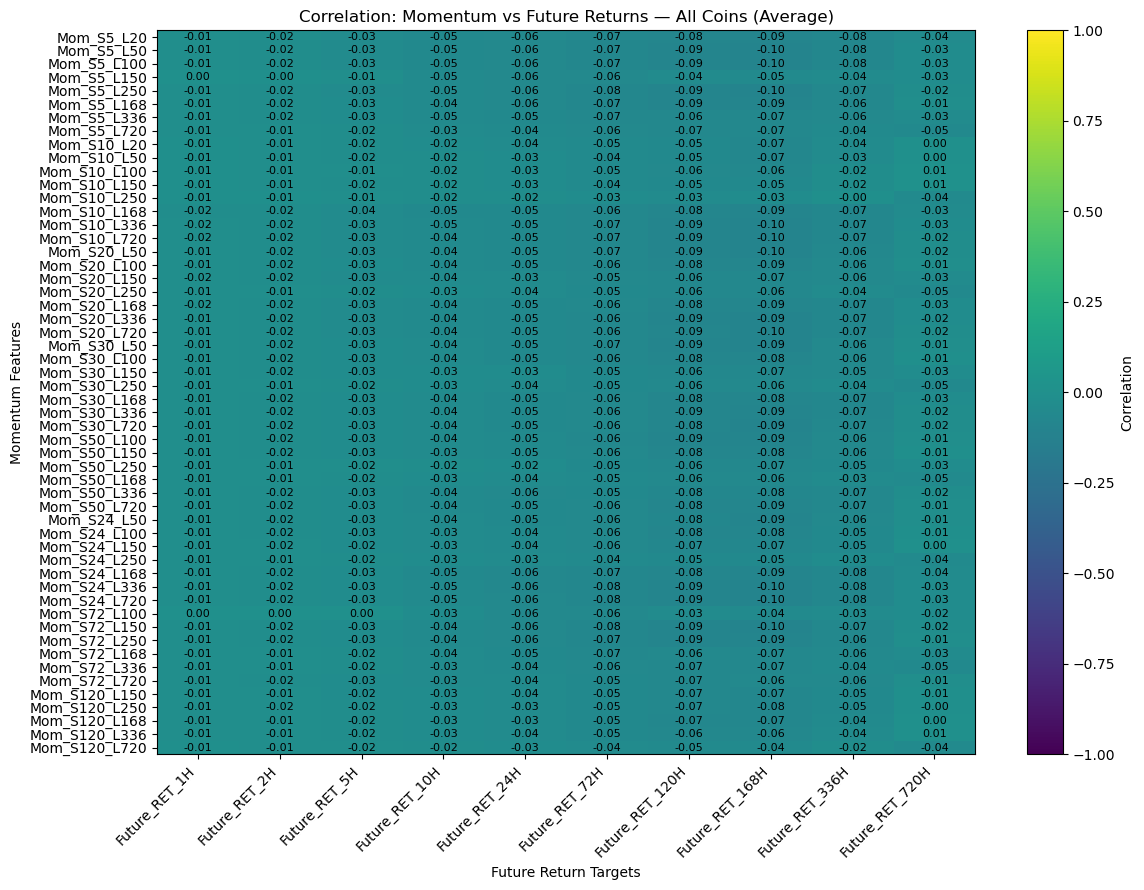

In [37]:
corr_matrix = plot_coin_corr(long_df, coin="all")

### Momentum Indicator Results Summary

Across all coins and time horizons, momentum features show **consistent negative correlations** (≈ −0.03 to −0.10) with future returns.  
This indicates a **weak but widespread mean-reversion effect** — short-term strength tends to be followed by small reversals, which become slightly stronger over multi-day horizons.  
No specific MA pair dominates, suggesting a **broad, systemic reversal pattern** rather than a parameter-specific effect.


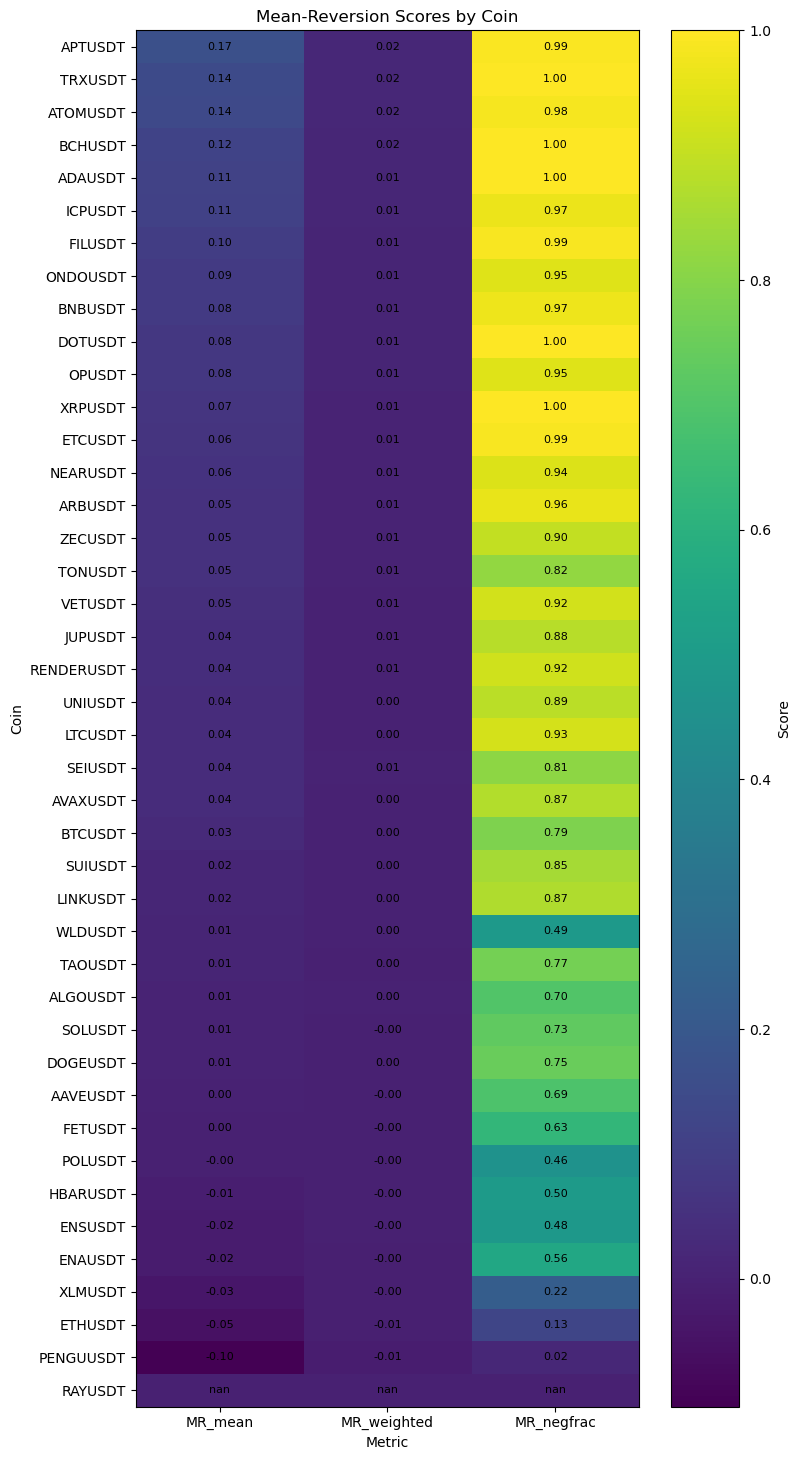

In [39]:
def _natural_horizon_sort(cols, target_prefix):
    """
    Sort target columns like 'Future_RET_1H','Future_RET_5H','Future_RET_12H' by the numeric horizon.
    Falls back to original order if no integer found.
    """
    def key(c):
        if not c.startswith(target_prefix):
            return (1e9, c)
        m = re.search(r'(\d+)', c)
        return (int(m.group(1)) if m else 1e9, c)
    return sorted(cols, key=key)

def _coin_corr_block(df, momentum_cols, target_cols):
    """Return (len(momentum_cols) x len(target_cols)) correlation block."""
    corr = df.loc[:, momentum_cols + target_cols].corr()
    return corr.loc[momentum_cols, target_cols]

def compute_mr_scores(
    long_df: pd.DataFrame,
    momentum_prefix: str = "Mom_S",
    target_prefix: str = "Future_RET_",
    weights: np.ndarray  = None,
) -> pd.DataFrame:
    """
    Compute three mean-reversion scores per coin:
      - MR_mean:     −mean(all correlations)
      - MR_weighted: −mean( corr_matrix @ weights )   (if weights is provided)
      - MR_negfrac:   fraction of correlations < 0

    Returns
    -------
    pd.DataFrame with index=coin and columns ['MR_mean','MR_weighted','MR_negfrac'].
    'MR_weighted' is NaN if weights not provided.
    """
    if "coin" not in long_df.columns:
        raise ValueError("long_df must contain a 'coin' column.")

    # Identify columns
    momentum_cols = [c for c in long_df.columns if c.startswith(momentum_prefix)]
    target_cols   = [c for c in long_df.columns if c.startswith(target_prefix)]
    if not momentum_cols or not target_cols:
        raise ValueError("Could not find momentum/target columns by the given prefixes.")

    # Sort targets naturally by horizon so weights align intuitively
    target_cols = _natural_horizon_sort(target_cols, target_prefix)

    # Validate weights (optional)
    use_weighted = weights is not None
    if use_weighted:
        weights = np.asarray(weights, dtype=float).ravel()
        if len(weights) != len(target_cols):
            raise ValueError(
                f"weights length ({len(weights)}) must match number of targets ({len(target_cols)})."
            )

    out = []
    for coin, dfc in long_df.groupby("coin", sort=False):
        if dfc.empty:
            continue

        # Build correlation block (momentum x targets)
        try:
            block = _coin_corr_block(dfc, momentum_cols, target_cols).to_numpy()
        except KeyError:
            # If some columns are fully missing for this coin
            continue

        # Handle all-NaN safely
        if np.all(np.isnan(block)):
            mr_mean = np.nan
            mr_w    = np.nan if use_weighted else np.nan
            mr_nf   = np.nan
        else:
            # MR_mean
            mr_mean = -np.nanmean(block)

            # MR_weighted (if provided): average over momentum rows after target weighting
            if use_weighted:
                # (M x T) @ (T,) -> (M,) then mean over M
                row_scores = np.nansum(block * weights[None, :], axis=1) / np.sum(~np.isnan(block), axis=1).clip(min=1)
                mr_w = -np.nanmean(row_scores)
            else:
                mr_w = np.nan

            # MR_negfrac
            mr_nf = np.nanmean(block < 0)

        out.append((coin, mr_mean, mr_w, mr_nf))

    scores = pd.DataFrame(out, columns=["coin", "MR_mean", "MR_weighted", "MR_negfrac"]).set_index("coin")
    return scores

def plot_mr_scores_matrix(
    scores: pd.DataFrame,
    figsize=(10, 0.6),
    sort_by: str = "MR_mean"
):
    """
    Plot a coins × metrics heatmap (matplotlib, no seaborn).
    If you want a taller matrix, increase figsize height.

    Parameters
    ----------
    scores : DataFrame
        Output of compute_mr_scores (index=coin, columns include MR_mean/MR_weighted/MR_negfrac).
    figsize : tuple
        Figure size. Height should scale with number of coins (e.g., (10, max(4, 0.35*len(coins)))).
    sort_by : str
        Column to sort coins by (e.g., 'MR_mean', 'MR_weighted', or 'MR_negfrac').
    """
    if sort_by not in scores.columns:
        raise ValueError(f"sort_by must be one of {list(scores.columns)}")

    # Sort and select columns in a clean order
    cols = [c for c in ["MR_mean", "MR_weighted", "MR_negfrac"] if c in scores.columns]
    S = scores.loc[:, cols].sort_values(sort_by, ascending=False)

    # Plot
    mat = S.to_numpy()
    mat_disp = np.nan_to_num(mat, nan=0.0)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(mat_disp, aspect="auto")

    # Ticks / labels
    ax.set_yticks(range(len(S)))
    ax.set_yticklabels(S.index)
    ax.set_xticks(range(len(cols)))
    ax.set_xticklabels(cols, rotation=0, ha="center")

    ax.set_title("Mean-Reversion Scores by Coin")
    ax.set_xlabel("Metric")
    ax.set_ylabel("Coin")

    # Colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Score")

    # Annotate values
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            v = S.iat[i, j]
            txt = "nan" if pd.isna(v) else f"{v:.2f}"
            ax.text(j, i, txt, ha="center", va="center", fontsize=8)

    fig.tight_layout()
    plt.show()


weights = np.array([0.02, 0.03, 0.05, 0.07, 0.10, 0.12, 0.15, 0.18, 0.14, 0.14])
weights = weights / weights.sum()
scores = compute_mr_scores(long_df, weights=weights)  # or weights=None to skip weighted column
plot_mr_scores_matrix(scores, figsize=(8, max(4, 0.35*len(scores))))


### Understanding the Mean-Reversion Score Columns

- **MR_mean** – Shows how strong the mean-reversion effect is on average.  
  Higher = stronger tendency to move opposite to recent momentum.

- **MR_weighted** – Same as MR_mean but gives more importance to certain time horizons (e.g., longer ones).

- **MR_negfrac** – Tells how consistent the mean-reversion is.  
  1.0 means almost all correlations are negative (very consistent mean reversion).
